<a href="https://colab.research.google.com/github/LeonGoergen/DocumentClassification/blob/main/classification/Traditional_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A comprehensive overview and explanation of the different models, feature extraction methods and hyperparameters can be found in scikit-learn's
[documentation](https://scikit-learn.org/stable/)

# Dependencies

## Imports

In [ ]:
!pip uninstall scikit-learn
!pip install -v scikit-learn==1.0.2

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/scikit_learn-1.2.2.dist-info/*
    /usr/local/lib/python3.9/dist-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.9/dist-packages/sklearn/*
Proceed (Y/n)? y
  Successfully uninstalled scikit-learn-1.2.2
Using pip 22.0.4 from /usr/local/lib/python3.9/dist-packages/pip (python 3.9)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 17.4 MB/s eta 0:00:00


In [ ]:
# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import FunctionTransformer

# Classifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import time

# For Data Management
import numpy as np
import pandas as pd
import re
import json
import joblib

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Bachelor Thesis/Datasets/train.csv', sep="\t", header=0)
test = pd.read_csv('/content/drive/MyDrive/Bachelor Thesis/Datasets/test.csv', sep="\t", header=0)

In [ ]:
# get content + labels
X_train = train['Consumer complaint narrative'].astype("str")
y_train = train['Product'].astype("str")

## Functions

In [ ]:
def calculate_accuracy(y_actu, y_pred):
    return accuracy_score(y_actu, y_pred)

def calculate_precision(y_actu, y_pred,average='macro'):
    return precision_score(y_actu, y_pred,average=average)

def calculate_recall(y_actu, y_pred,average='macro'):
    return recall_score(y_actu, y_pred,average=average)

def calculate_f1(y_actu, y_pred,average='macro'):
    return f1_score(y_actu, y_pred,average=average)

def save_results(metrics, algorithm, method):
    name = "/content/drive/MyDrive/Bachelor Thesis/Classification/FOSS Results/" + algorithm + method + ".json"
    with open(name, "w") as outfile:
        json.dump(metrics, outfile)

def evaluate_model(y_actu, y_pred, time, training_time, algorithm, method=""):
    metrics = {}
    metrics["Algorithm"] = algorithm
    metrics["Method"] = method
    metrics["Accuracy"] = round(calculate_accuracy(y_actu, y_pred)*100, 4)
    metrics["Precision (Macro Average)"] = round(calculate_precision(y_actu, y_pred,average='macro')*100, 4)
    metrics["Precision (Micro Average)"] = round(calculate_precision(y_actu, y_pred,average='micro')*100, 4)
    metrics["Recall (Macro Average)"] = round(calculate_recall(y_actu, y_pred,average='macro')*100, 4)
    metrics["Recall (Micro Average)"] = round(calculate_recall(y_actu, y_pred,average='micro')*100, 4)
    metrics["F1-Score (Macro Average)"] = round(calculate_f1(y_actu, y_pred,average='macro')*100, 4)
    metrics["F1-Score (Micro Average)"] = round(calculate_f1(y_actu, y_pred,average='micro')*100, 4)
    metrics["time per document (ms)"] = time
    metrics["training time (min)"] = training_time

    save_results(metrics, algorithm, method)

    return metrics

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()

# Naive Bayes Classifier

## Bag-of-Words

### Setup

In [ ]:
text_clf = Pipeline([('bow', CountVectorizer(ngram_range=(1,3), min_df=3, analyzer='word')),
                     ('clf', MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None))])

In [ ]:
start = time.time()
text_clf.fit(X_train, y_train)
training_time = time.time() - start

In [ ]:
modelname = '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/nbcbow.joblib'
joblib.dump(text_clf, modelname)

['/content/drive/MyDrive/Bachelor Thesis/Classification/Models/nbcbow.joblib']

### Inference

In [ ]:
text_clf = joblib.load('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/nbcbow.joblib')

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = text_clf.predict([sample])
    y_pred.append(prediction[0])
    y_actu.append(row['Product'])
    predictions.append([prediction[0], row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [06:07<00:00, 38.45it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
labels = text_clf.classes_

print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "NBC", "BOW")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,NBC
1,Method,BOW
2,Accuracy,74.0646
3,Precision (Macro Average),73.5142
4,Precision (Micro Average),74.0646
5,Recall (Macro Average),73.9713
6,Recall (Micro Average),74.0646
7,F1-Score (Macro Average),73.6144
8,F1-Score (Micro Average),74.0646
9,time per document (ms),12.25


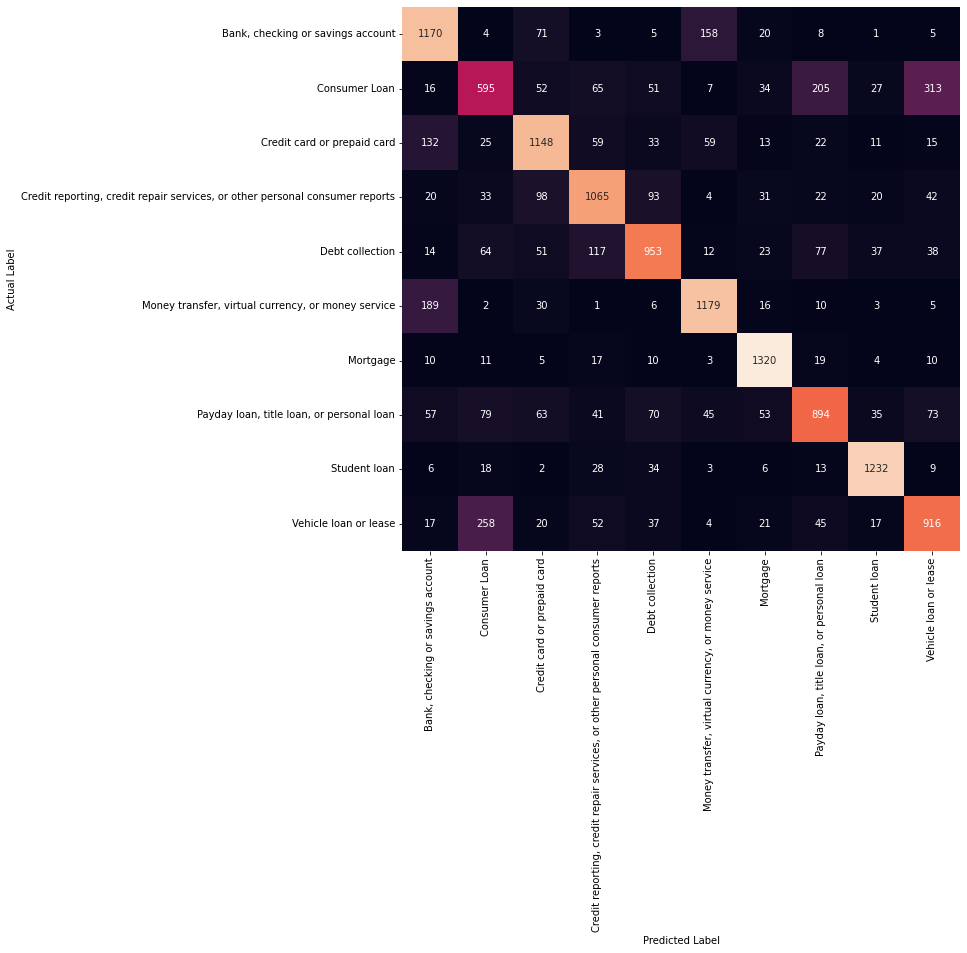

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

## TF-IDF

### Setup

In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer(smooth_idf=True, sublinear_tf=True, norm='l2', ngram_range=(1,3), min_df=3, analyzer='word')),
                     ('clf', MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None))])

In [ ]:
start = time.time()
text_clf.fit(X_train, y_train)
training_time = time.time() - start

In [ ]:
modelname = '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/nbctfidf.joblib'
joblib.dump(text_clf, modelname)

['/content/drive/MyDrive/Bachelor Thesis/Classification/Models/nbctfidf.joblib']

### Inference

In [ ]:
text_clf = joblib.load('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/nbctfidf.joblib')

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = text_clf.predict([sample])
    y_pred.append(prediction[0])
    y_actu.append(row['Product'])
    predictions.append([prediction[0], row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [09:03<00:00, 26.01it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
labels = text_clf.classes_

print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "NBC", "TF-IDF")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,NBC
1,Method,TF-IDF
2,Accuracy,73.7959
3,Precision (Macro Average),73.3427
4,Precision (Micro Average),73.7959
5,Recall (Macro Average),73.688
6,Recall (Micro Average),73.7959
7,F1-Score (Macro Average),72.8279
8,F1-Score (Micro Average),73.7959
9,time per document (ms),18.9


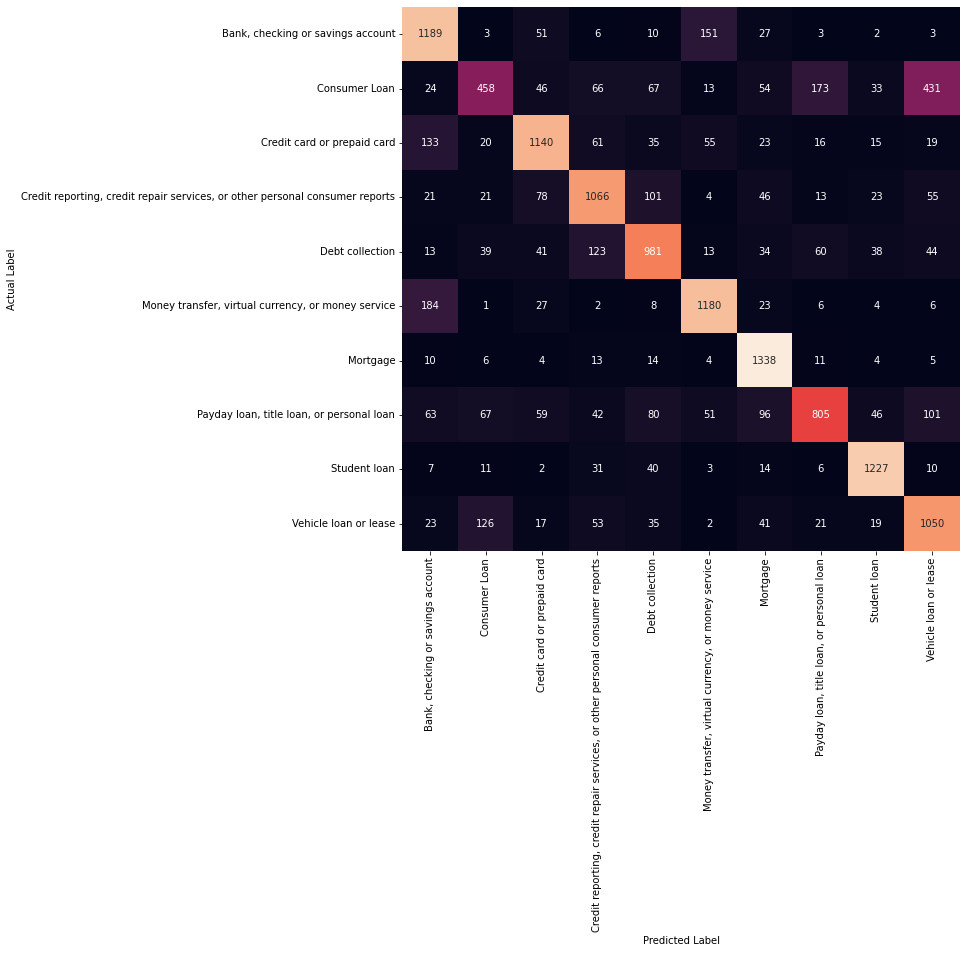

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

## LSA

### Setup

In [ ]:
def to_positive(x):
    return x + abs(x.min())

In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer(smooth_idf=True, sublinear_tf=True, norm='l2', ngram_range=(1,3), min_df=3, analyzer='word')),
                     ('svd', TruncatedSVD(n_components=100)),
                     ('to_positive', FunctionTransformer(to_positive, validate=False)),
                     ('clf', ComplementNB(alpha=1.0, fit_prior=True, class_prior=None))])

In [ ]:
start = time.time()
text_clf.fit(X_train, y_train)
training_time = time.time() - start

In [ ]:
modelname = '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/nbclsa.joblib'
joblib.dump(text_clf, modelname)

['/content/drive/MyDrive/Bachelor Thesis/Classification/Models/nbclsa.joblib']

### Inference

In [ ]:
text_clf = joblib.load('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/nbclsa.joblib')

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = text_clf.predict([sample])
    y_pred.append(prediction[0])
    y_actu.append(row['Product'])
    predictions.append([prediction[0], row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [1:07:47<00:00,  3.48it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
labels = text_clf.classes_

print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "NBC", "LSA")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,NBC
1,Method,LSA
2,Accuracy,66.2565
3,Precision (Macro Average),66.0032
4,Precision (Micro Average),66.2565
5,Recall (Macro Average),66.0628
6,Recall (Micro Average),66.2565
7,F1-Score (Macro Average),63.4439
8,F1-Score (Micro Average),66.2565
9,time per document (ms),185.71


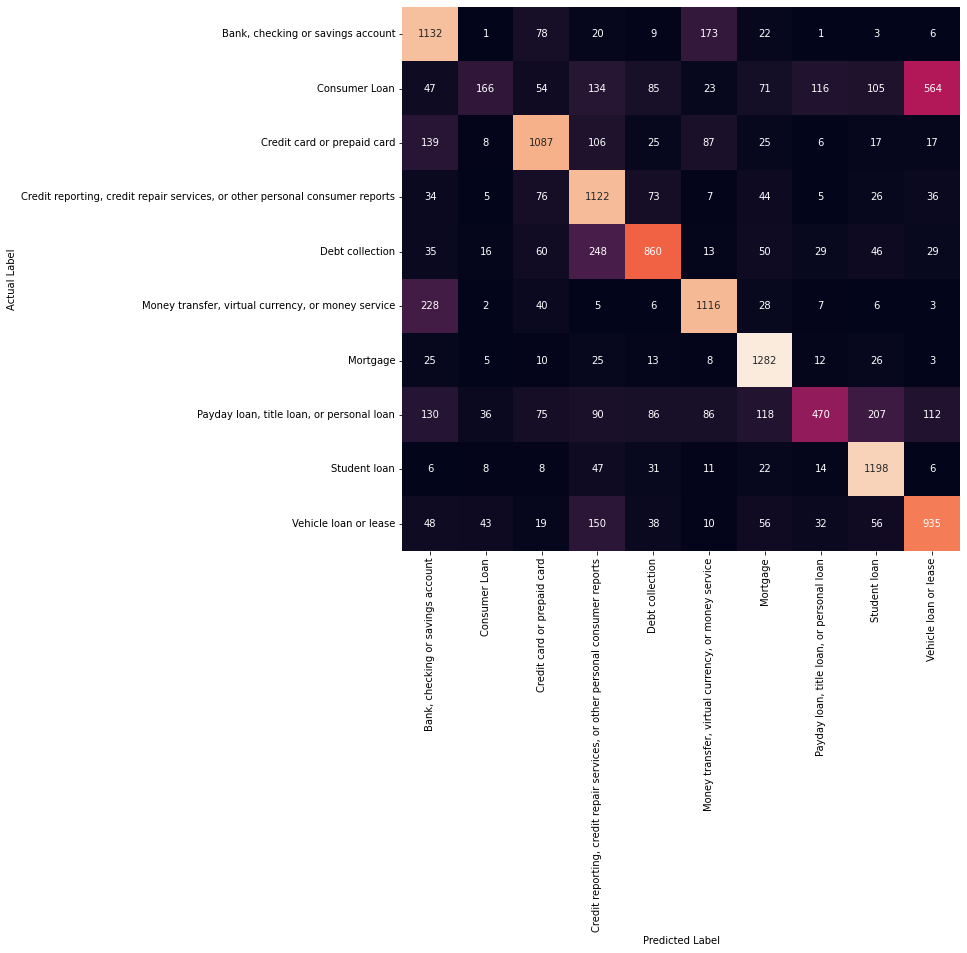

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

# K-Nearest-Neighbor

## Bag-of-Words

### Setup

In [ ]:
text_clf = Pipeline([('bow', CountVectorizer(ngram_range=(1,3), min_df=3, analyzer='word')),
                     ('clf', KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto',metric='minkowski'))])

In [ ]:
start = time.time()
text_clf.fit(X_train, y_train)
training_time = time.time() - start

In [ ]:
modelname = '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/knnbow.joblib'
joblib.dump(text_clf, modelname)

### Inference

In [ ]:
text_clf = joblib.load('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/knnbow.joblib')

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = text_clf.predict([sample])
    y_pred.append(prediction[0])
    y_actu.append(row['Product'])
    predictions.append([prediction[0], row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [4:26:23<00:00,  1.13s/it]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
labels = text_clf.classes_

print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "kNN", "BOW")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,kNN
1,Method,BOW
2,Accuracy,44.7627
3,Precision (Macro Average),48.8381
4,Precision (Micro Average),44.7627
5,Recall (Macro Average),44.6237
6,Recall (Micro Average),44.7627
7,F1-Score (Macro Average),44.8495
8,F1-Score (Micro Average),44.7627
9,time per document (ms),725.39


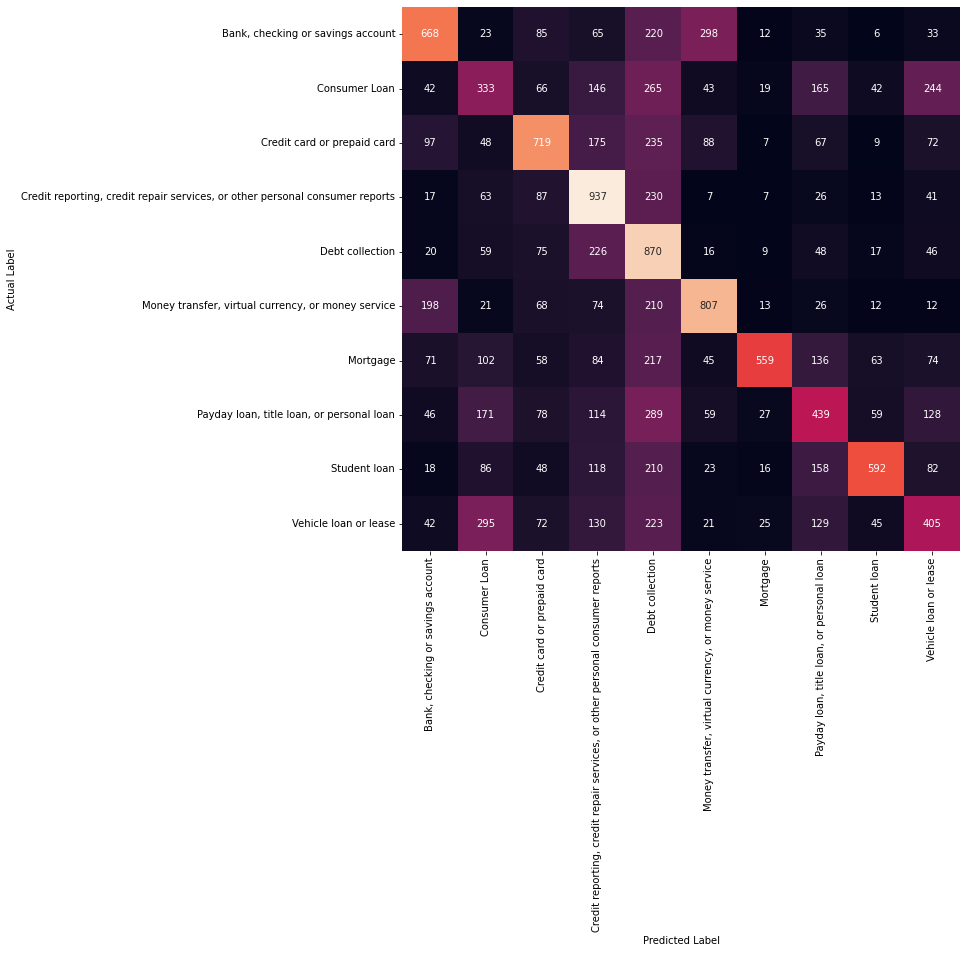

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

## TF-IDF

### Setup

In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer(smooth_idf=True, sublinear_tf=True, norm='l2', ngram_range=(1,3), min_df=3, analyzer='word')),
                     ('clf', KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto',metric='minkowski'))])

In [ ]:
start = time.time()
text_clf.fit(X_train, y_train)
training_time = time.time() - start

In [ ]:
modelname = '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/knntfidf.joblib'
joblib.dump(text_clf, modelname)

['/content/drive/MyDrive/Bachelor Thesis/Classification/Models/knntfidf.joblib']

### Inference

In [ ]:
text_clf = joblib.load('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/knntfidf.joblib')

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = text_clf.predict([sample])
    y_pred.append(prediction[0])
    y_actu.append(row['Product'])
    predictions.append([prediction[0], row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [6:07:10<00:00,  1.56s/it]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
labels = text_clf.classes_

print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "kNN", "TF-IDF")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,kNN
1,Method,TF-IDF
2,Accuracy,13.2824
3,Precision (Macro Average),48.5288
4,Precision (Micro Average),13.2824
5,Recall (Macro Average),13.0511
6,Recall (Micro Average),13.2824
7,F1-Score (Macro Average),7.996
8,F1-Score (Micro Average),13.2824
9,time per document (ms),512.78


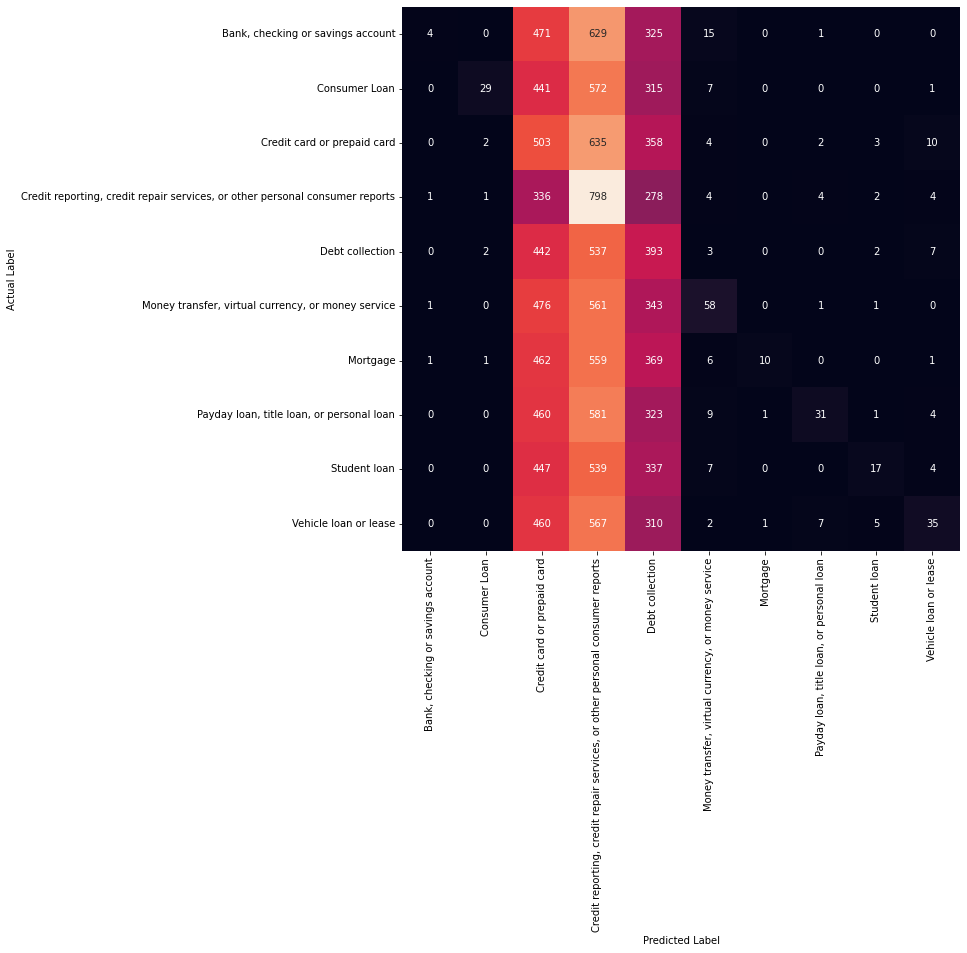

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

## LSA

### Setup

In [ ]:
def to_positive(x):
    return x + abs(x.min())

In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer(smooth_idf=True, sublinear_tf=True, norm='l2', ngram_range=(1,3), min_df=3, analyzer='word')),
                     ('svd', TruncatedSVD(n_components=100)),
                     ('to_positive', FunctionTransformer(to_positive, validate=False)),
                     ('clf', KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto',metric='minkowski'))])

In [ ]:
start = time.time()
text_clf.fit(X_train, y_train)
training_time = time.time() - start

In [ ]:
modelname = '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/knnlsa.joblib'
joblib.dump(text_clf, modelname)

['/content/drive/MyDrive/Bachelor Thesis/Classification/Models/knnlsa.joblib']

### Inference

In [ ]:
text_clf = joblib.load('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/knnlsa.joblib')

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = text_clf.predict([sample])
    y_pred.append(prediction[0])
    y_actu.append(row['Product'])
    predictions.append([prediction[0], row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [1:39:21<00:00,  2.37it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
labels = text_clf.classes_

print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "kNN", "LSA")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,kNN
1,Method,LSA
2,Accuracy,15.0294
3,Precision (Macro Average),35.3771
4,Precision (Micro Average),15.0294
5,Recall (Macro Average),15.1705
6,Recall (Micro Average),15.0294
7,F1-Score (Macro Average),8.8469
8,F1-Score (Micro Average),15.0294
9,time per document (ms),222.66


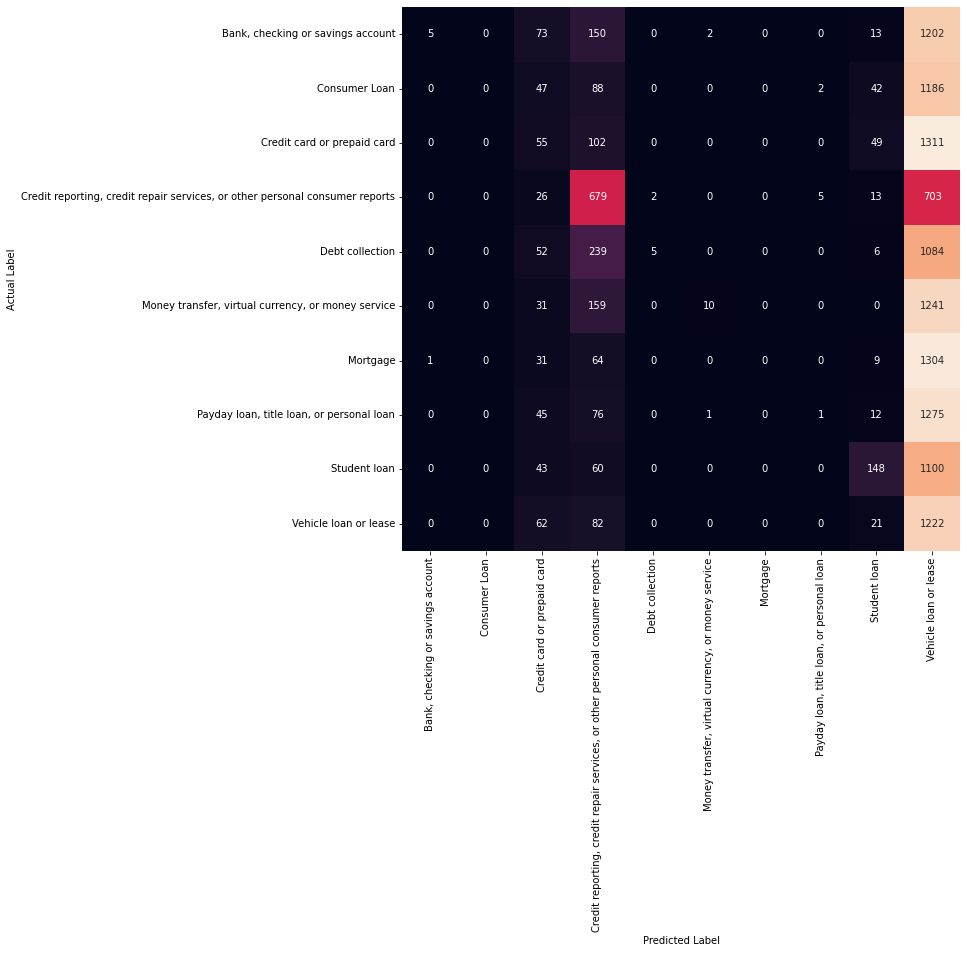

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

# Decision Tree

## Bag-of-Words

### Setup

In [ ]:
text_clf = Pipeline([('bow', CountVectorizer(ngram_range=(1,3), min_df=3, analyzer='word')),
                     ('clf', DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None))])

In [ ]:
start = time.time()
text_clf.fit(X_train, y_train)
training_time = time.time() - start

In [ ]:
modelname = '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/dtbow.joblib'
joblib.dump(text_clf, modelname)

['/content/drive/MyDrive/Bachelor Thesis/Classification/Models/dtbow.joblib']

### Inference

In [ ]:
text_clf = joblib.load('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/dtbow.joblib')

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = text_clf.predict([sample])
    y_pred.append(prediction[0])
    y_actu.append(row['Product'])
    predictions.append([prediction[0], row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [00:20<00:00, 688.74it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
labels = text_clf.classes_

print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "DecisionTree", "BOW")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,DecisionTree
1,Method,BOW
2,Accuracy,61.8361
3,Precision (Macro Average),61.7298
4,Precision (Micro Average),61.8361
5,Recall (Macro Average),61.8293
6,Recall (Micro Average),61.8361
7,F1-Score (Macro Average),61.7681
8,F1-Score (Micro Average),61.8361
9,time per document (ms),1.55


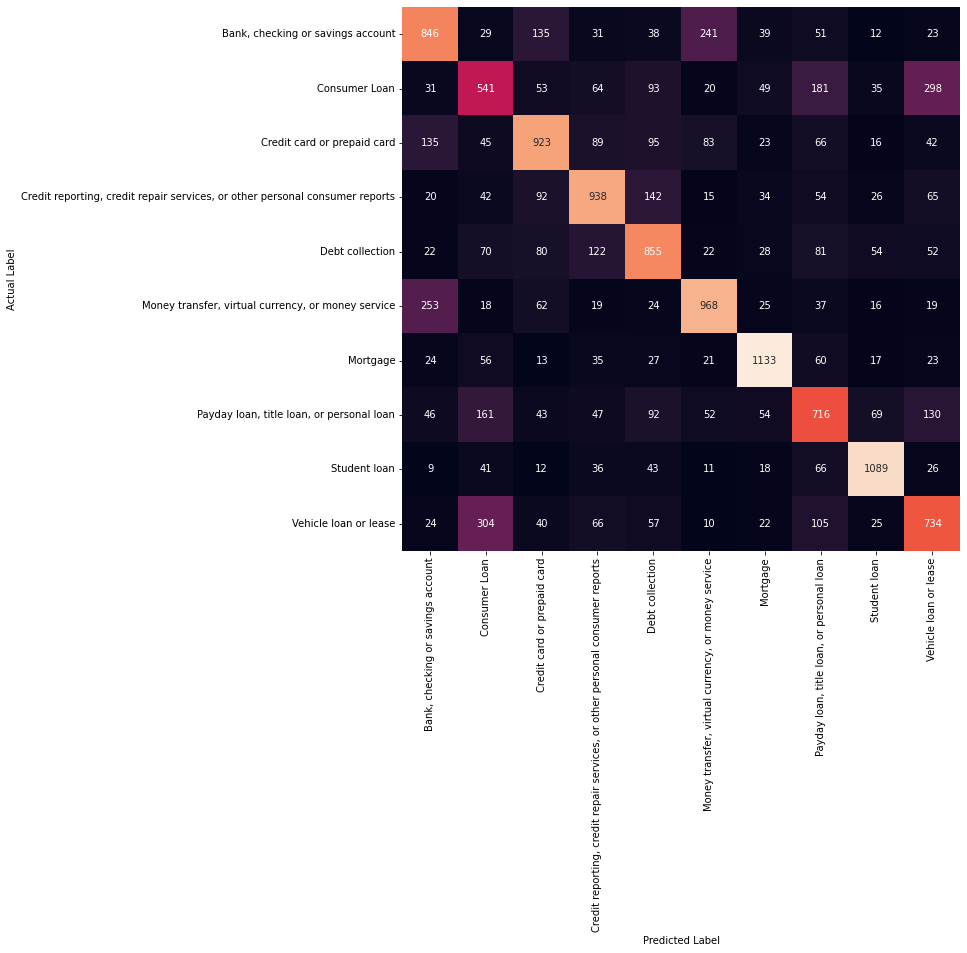

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

## TF-IDF

### Setup

In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer(smooth_idf=True, sublinear_tf=True, norm='l2', ngram_range=(1,3), min_df=3, analyzer='word')),
                     ('clf', DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None))])

In [ ]:
start = time.time()
text_clf.fit(X_train, y_train)
training_time = time.time() - start

In [ ]:
modelname = '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/dttfidf.joblib'
joblib.dump(text_clf, modelname)

['/content/drive/MyDrive/Bachelor Thesis/Classification/Models/dttfidf.joblib']

### Inference

In [ ]:
text_clf = joblib.load('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/dttfidf.joblib')

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = text_clf.predict([sample])
    y_pred.append(prediction[0])
    y_actu.append(row['Product'])
    predictions.append([prediction[0], row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [01:33<00:00, 150.73it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
labels = text_clf.classes_

print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "DecisionTree", "TF-IDF")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,DecisionTree
1,Method,TF-IDF
2,Accuracy,59.9194
3,Precision (Macro Average),60.0072
4,Precision (Micro Average),59.9194
5,Recall (Macro Average),59.8806
6,Recall (Micro Average),59.9194
7,F1-Score (Macro Average),59.9274
8,F1-Score (Micro Average),59.9194
9,time per document (ms),8.74


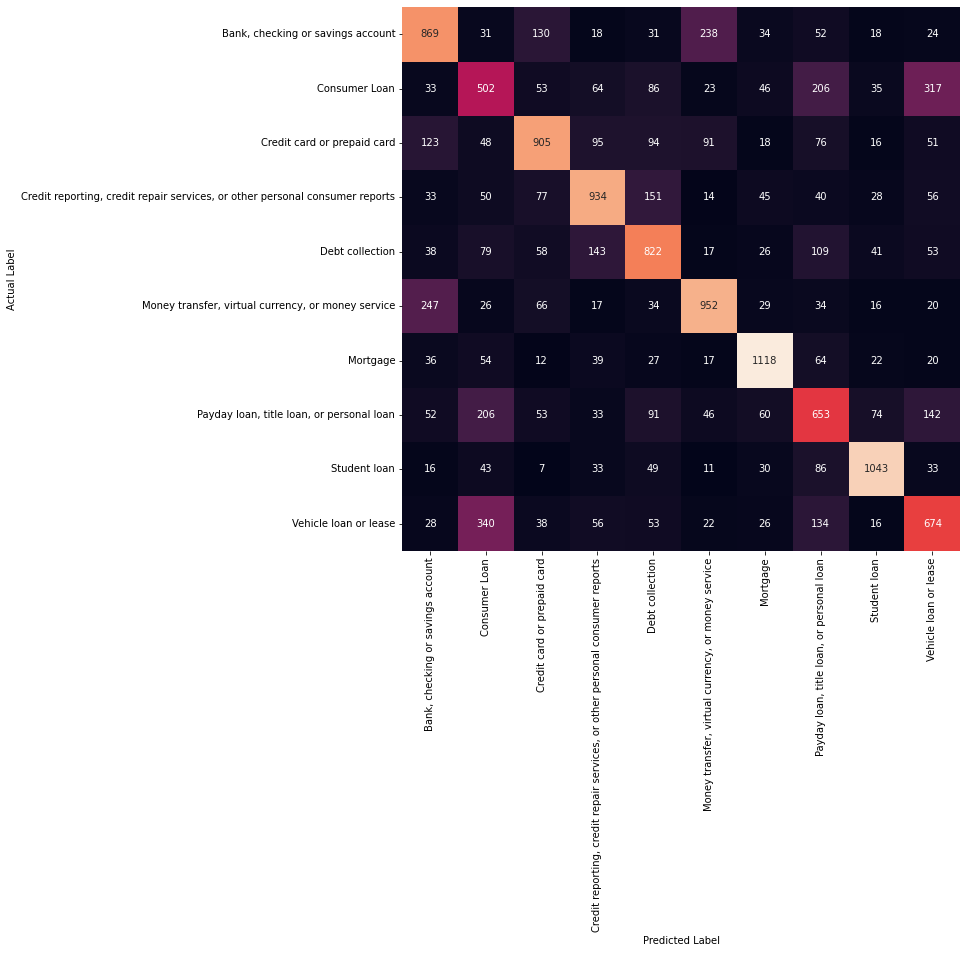

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

## LSA

### Setup

In [ ]:
def to_positive(x):
    return x + abs(x.min())

In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer(smooth_idf=True, sublinear_tf=True, norm='l2', ngram_range=(1,3), min_df=3, analyzer='word')),
                     ('svd', TruncatedSVD(n_components=100)),
                     ('to_positive', FunctionTransformer(to_positive, validate=False)),
                     ('clf', DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None))])

In [ ]:
start = time.time()
text_clf.fit(X_train, y_train)
training_time = time.time() - start

In [ ]:
modelname = '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/dtlsa.joblib'
joblib.dump(text_clf, modelname)

### Inference

In [ ]:
text_clf = joblib.load('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/dtlsa.joblib')

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = text_clf.predict([sample])
    y_pred.append(prediction[0])
    y_actu.append(row['Product'])
    predictions.append([prediction[0], row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [1:21:02<00:00,  2.91it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
labels = text_clf.classes_

print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "DecisionTree", "LSA")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,DecisionTree
1,Method,LSA
2,Accuracy,10.708
3,Precision (Macro Average),2.8387
4,Precision (Micro Average),10.708
5,Recall (Macro Average),9.9817
6,Recall (Micro Average),10.708
7,F1-Score (Macro Average),1.9774
8,F1-Score (Micro Average),10.708
9,time per document (ms),233.81


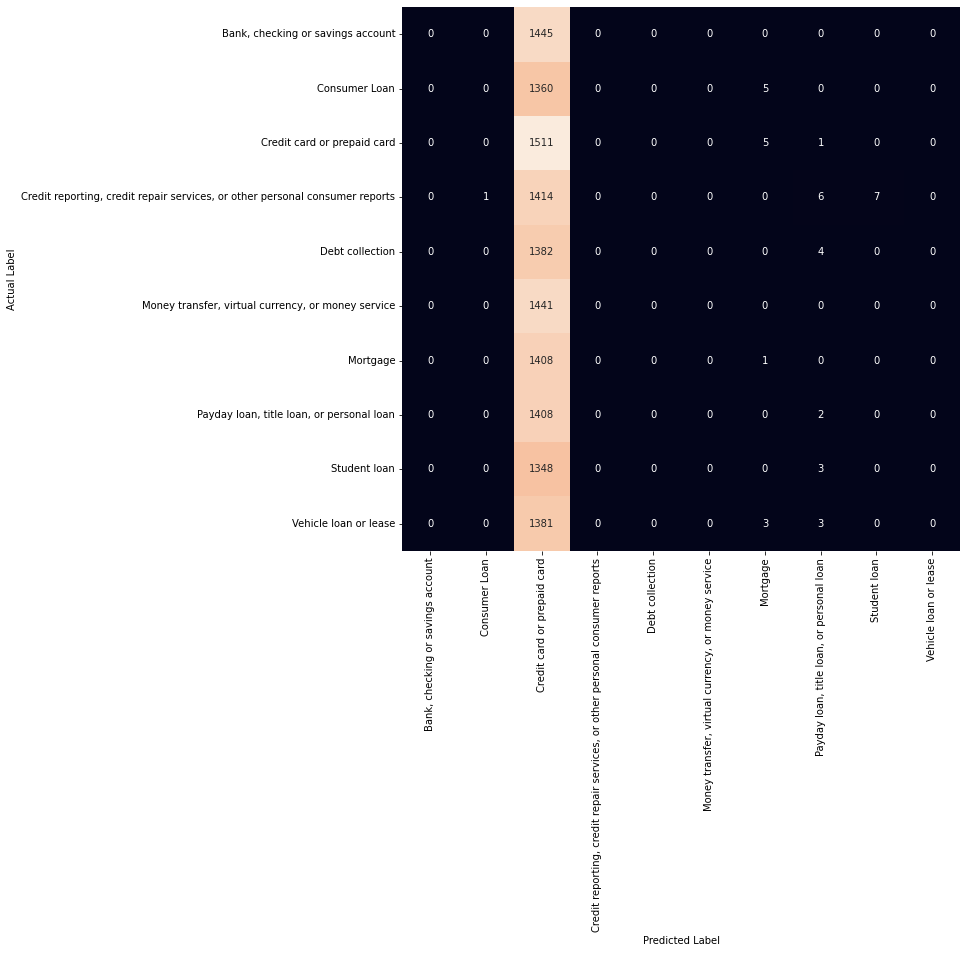

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

# Logistic Regression

## Bag-of-Words

### Setup

In [ ]:
text_clf = Pipeline([('bow', CountVectorizer(ngram_range=(1,3), min_df=3, analyzer='word')),
                     ('clf', LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000))])

In [ ]:
start = time.time()
text_clf.fit(X_train, y_train)
training_time = time.time() - start

In [ ]:
modelname = '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/lrbow.joblib'
joblib.dump(text_clf, modelname)

### Inference

In [ ]:
text_clf = joblib.load('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/lrbow.joblib')

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = text_clf.predict([sample])
    y_pred.append(prediction[0])
    y_actu.append(row['Product'])
    predictions.append([prediction[0], row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [05:56<00:00, 39.63it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
labels = text_clf.classes_

print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "LogisticRegression", "BOW")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,LogisticRegression
1,Method,BOW
2,Accuracy,74.3829
3,Precision (Macro Average),74.365
4,Precision (Micro Average),74.3829
5,Recall (Macro Average),74.3279
6,Recall (Micro Average),74.3829
7,F1-Score (Macro Average),74.3069
8,F1-Score (Micro Average),74.3829
9,time per document (ms),14.09


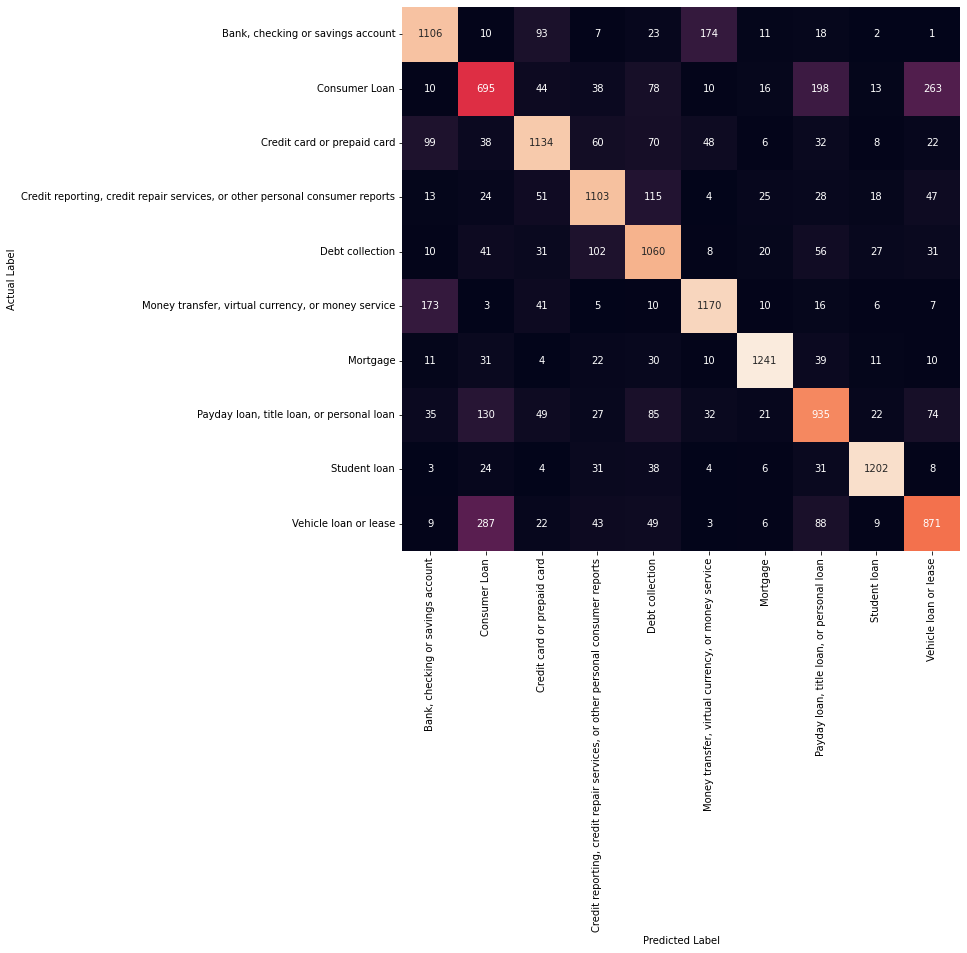

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

## TF-IDF

### Setup

In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer(smooth_idf=True, sublinear_tf=True, norm='l2', ngram_range=(1,3), min_df=3, analyzer='word')),
                     ('clf', LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000))])

In [ ]:
start = time.time()
text_clf.fit(X_train, y_train)
training_time = time.time() - start

In [ ]:
modelname = '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/lrtfidf.joblib'
joblib.dump(text_clf, modelname)

### Inference

In [ ]:
text_clf = joblib.load('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/lrtfidf.joblib')

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = text_clf.predict([sample])
    y_pred.append(prediction[0])
    y_actu.append(row['Product'])
    predictions.append([prediction[0], row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [04:14<00:00, 55.59it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
labels = text_clf.classes_

print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "LogisticRegression", "TF-IDF")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,LogisticRegression
1,Method,TF-IDF
2,Accuracy,76.4906
3,Precision (Macro Average),76.3048
4,Precision (Micro Average),76.4906
5,Recall (Macro Average),76.3916
6,Recall (Micro Average),76.4906
7,F1-Score (Macro Average),76.2512
8,F1-Score (Micro Average),76.4906
9,time per document (ms),17.99


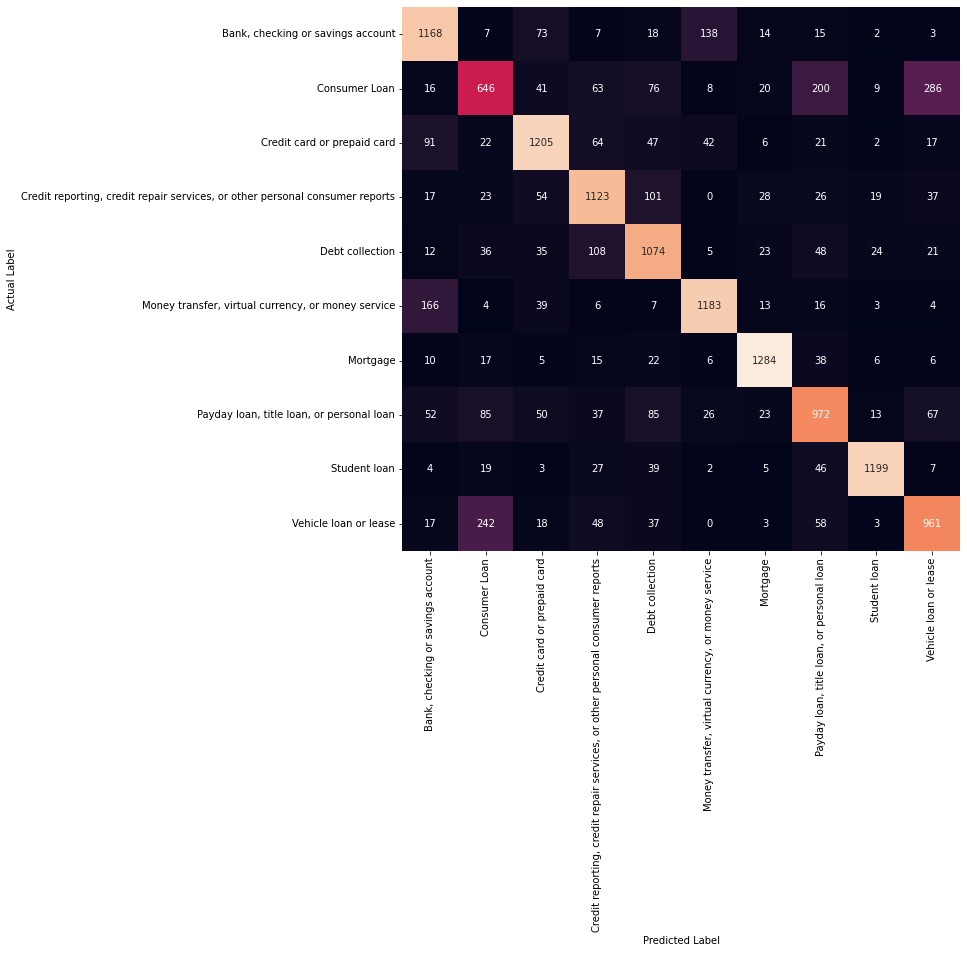

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

## LSA

### Setup

In [ ]:
def to_positive(x):
    return x + abs(x.min())

In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer(smooth_idf=True, sublinear_tf=True, norm='l2', ngram_range=(1,3), min_df=3, analyzer='word')),
                     ('svd', TruncatedSVD(n_components=100)),
                     ('to_positive', FunctionTransformer(to_positive, validate=False)),
                     ('clf', LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000))])

In [ ]:
start = time.time()
text_clf.fit(X_train, y_train)
training_time = time.time() - start

In [ ]:
modelname = '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/lrlsa.joblib'
joblib.dump(text_clf, modelname)

### Inference

In [ ]:
text_clf = joblib.load('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/lrlsa.joblib')

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = text_clf.predict([sample])
    y_pred.append(prediction[0])
    y_actu.append(row['Product'])
    predictions.append([prediction[0], row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [1:20:56<00:00,  2.91it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
labels = text_clf.classes_

print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "LogisticRegression", "LSA")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,LogisticRegression
1,Method,LSA
2,Accuracy,9.5551
3,Precision (Macro Average),0.9556
4,Precision (Micro Average),9.5551
5,Recall (Macro Average),10.0
6,Recall (Micro Average),9.5551
7,F1-Score (Macro Average),1.7445
8,F1-Score (Micro Average),9.5551
9,time per document (ms),202.33


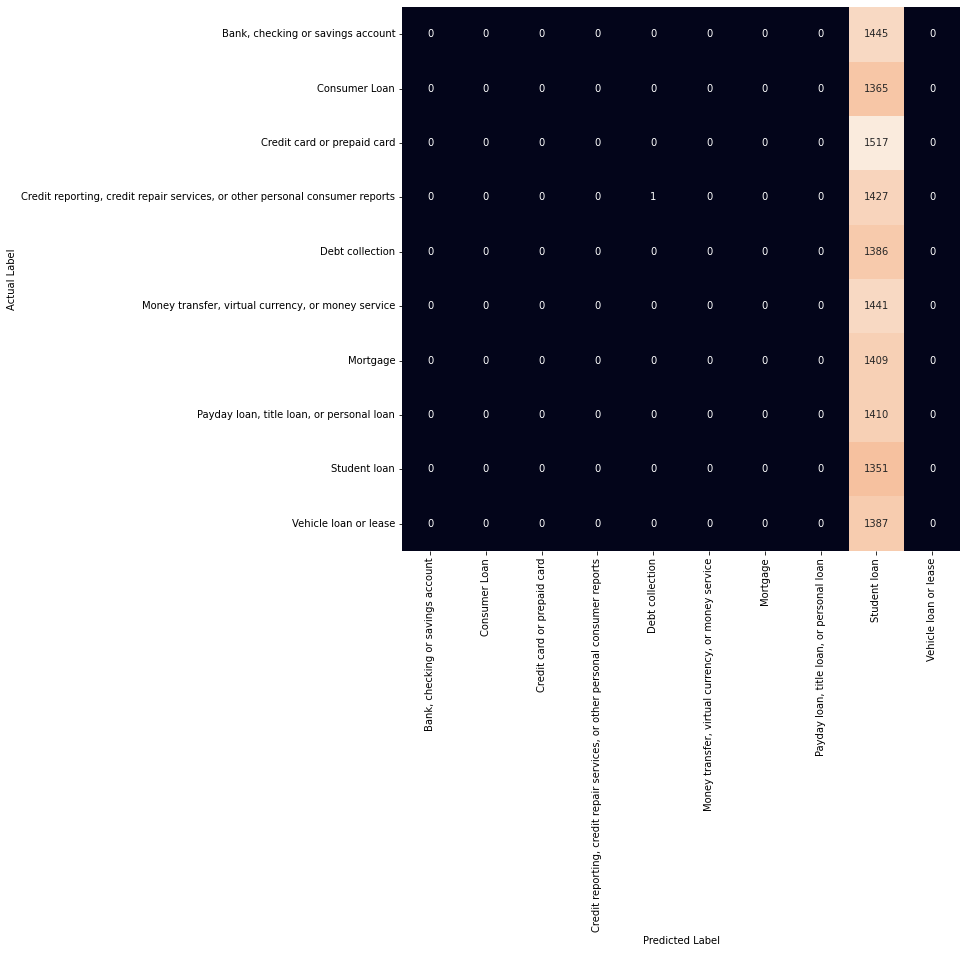

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

# Support Vector Machines

## Bag-of-Words

### Setup

In [ ]:
text_clf = Pipeline([('bow', CountVectorizer(ngram_range=(1,3), min_df=3, analyzer='word')),
                     ('clf', SVC(C=1,kernel='sigmoid',probability=True))])

In [ ]:
start = time.time()
text_clf.fit(X_train, y_train)
training_time = time.time() - start

In [ ]:
modelname = '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/svmbow.joblib'
joblib.dump(text_clf, modelname)

['/content/drive/MyDrive/Bachelor Thesis/Classification/Models/svmbow.joblib']

### Inference

In [ ]:
text_clf = joblib.load('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/svmbow.joblib')

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = text_clf.predict([sample])
    y_pred.append(prediction[0])
    y_actu.append(row['Product'])
    predictions.append([prediction[0], row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [20:24<00:00, 11.55it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
labels = text_clf.classes_

print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "SVM", "BOW")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,SVM
1,Method,BOW
2,Accuracy,56.2982
3,Precision (Macro Average),61.5315
4,Precision (Micro Average),56.2982
5,Recall (Macro Average),56.3063
6,Recall (Micro Average),56.2982
7,F1-Score (Macro Average),57.6291
8,F1-Score (Micro Average),56.2982
9,time per document (ms),87.78


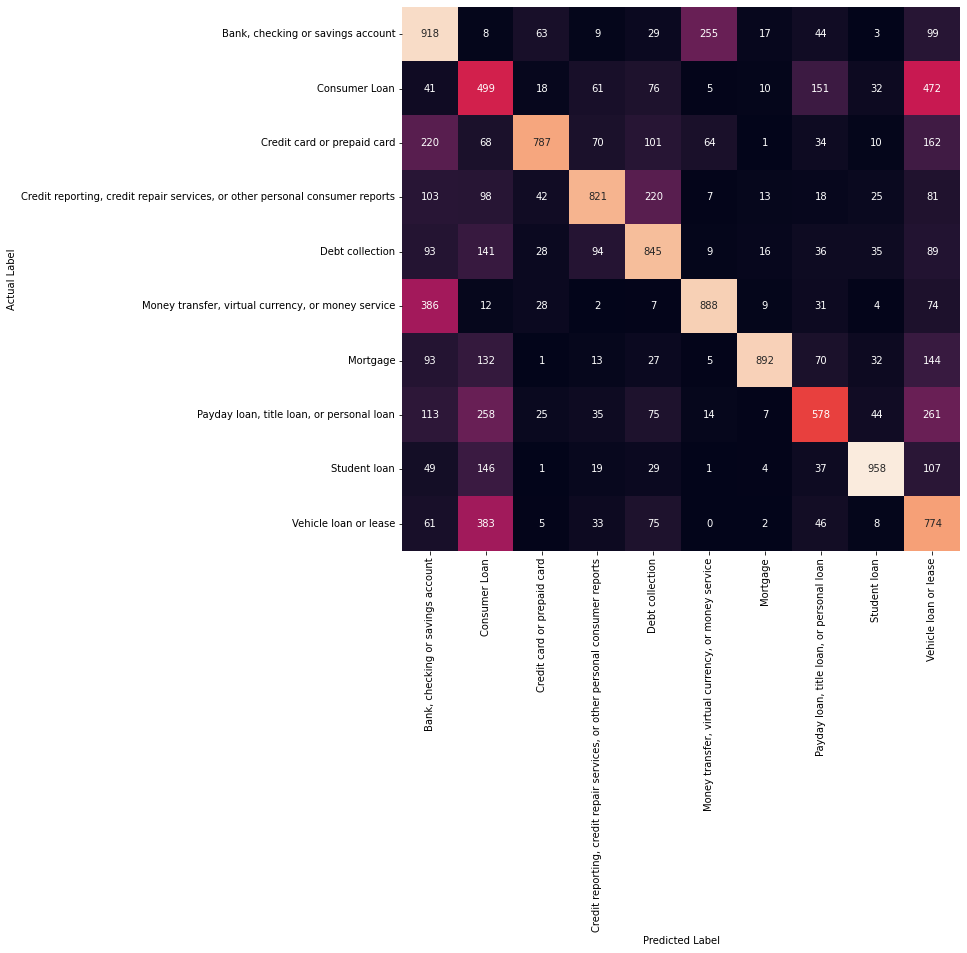

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

## TF-IDF

### Setup

In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer(smooth_idf=True, sublinear_tf=True, norm='l2', ngram_range=(1,3), min_df=3, analyzer='word')),
                     ('clf', SVC(C=1,kernel='sigmoid',probability=True))])

In [ ]:
start = time.time()
text_clf.fit(X_train, y_train)
training_time = time.time() - start

In [ ]:
modelname = '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/svmtfidf.joblib'
joblib.dump(text_clf, modelname)

['/content/drive/MyDrive/Bachelor Thesis/Classification/Models/svmtfidf.joblib']

### Inference

In [ ]:
text_clf = joblib.load('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/svmtfidf.joblib')

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = text_clf.predict([sample])
    y_pred.append(prediction[0])
    y_actu.append(row['Product'])
    predictions.append([prediction[0], row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [25:36<00:00,  9.20it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
labels = text_clf.classes_

print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "SVM", "TF-IDF")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,SVM
1,Method,TF-IDF
2,Accuracy,76.6886
3,Precision (Macro Average),76.6347
4,Precision (Micro Average),76.6886
5,Recall (Macro Average),76.5992
6,Recall (Micro Average),76.6886
7,F1-Score (Macro Average),76.5657
8,F1-Score (Micro Average),76.6886
9,time per document (ms),106.52


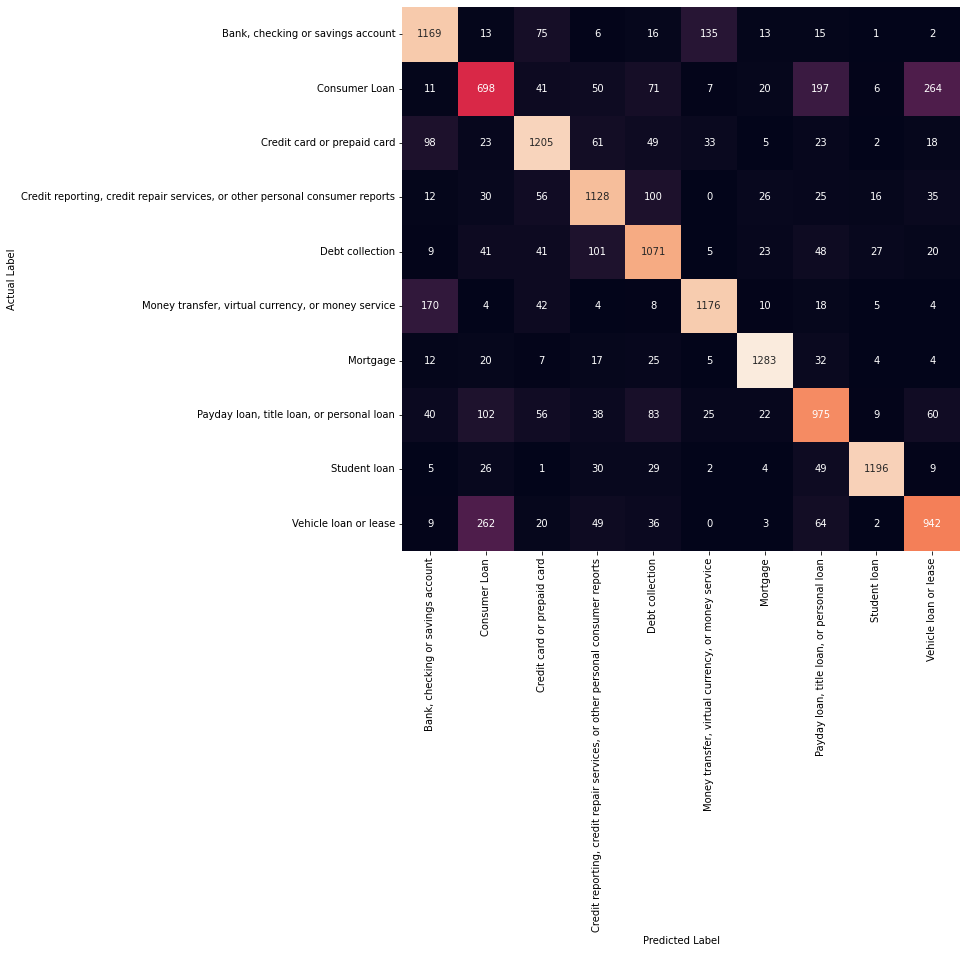

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

## LSA

### Setup

In [ ]:
def to_positive(x):
    return x + abs(x.min())

In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('svd', TruncatedSVD(n_components=100)),
                     ('clf', SVC(C=1,kernel='linear',probability=True))])

In [ ]:
start = time.time()
text_clf.fit(X_train, y_train)
training_time = time.time() - start

In [ ]:
modelname = '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/svmlsa.joblib'
joblib.dump(text_clf, modelname)

### Inference

In [ ]:
text_clf = joblib.load('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/svmlsa.joblib')

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = text_clf.predict([sample])
    y_pred.append(prediction[0])
    y_actu.append(row['Product'])
    predictions.append([prediction[0], row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [08:20<00:00, 28.27it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
labels = text_clf.classes_

print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "SVM", "LSA")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,SVM
1,Method,LSA
2,Accuracy,70.8112
3,Precision (Macro Average),70.5631
4,Precision (Micro Average),70.8112
5,Recall (Macro Average),70.691
6,Recall (Micro Average),70.8112
7,F1-Score (Macro Average),70.4161
8,F1-Score (Micro Average),70.8112
9,time per document (ms),23.57


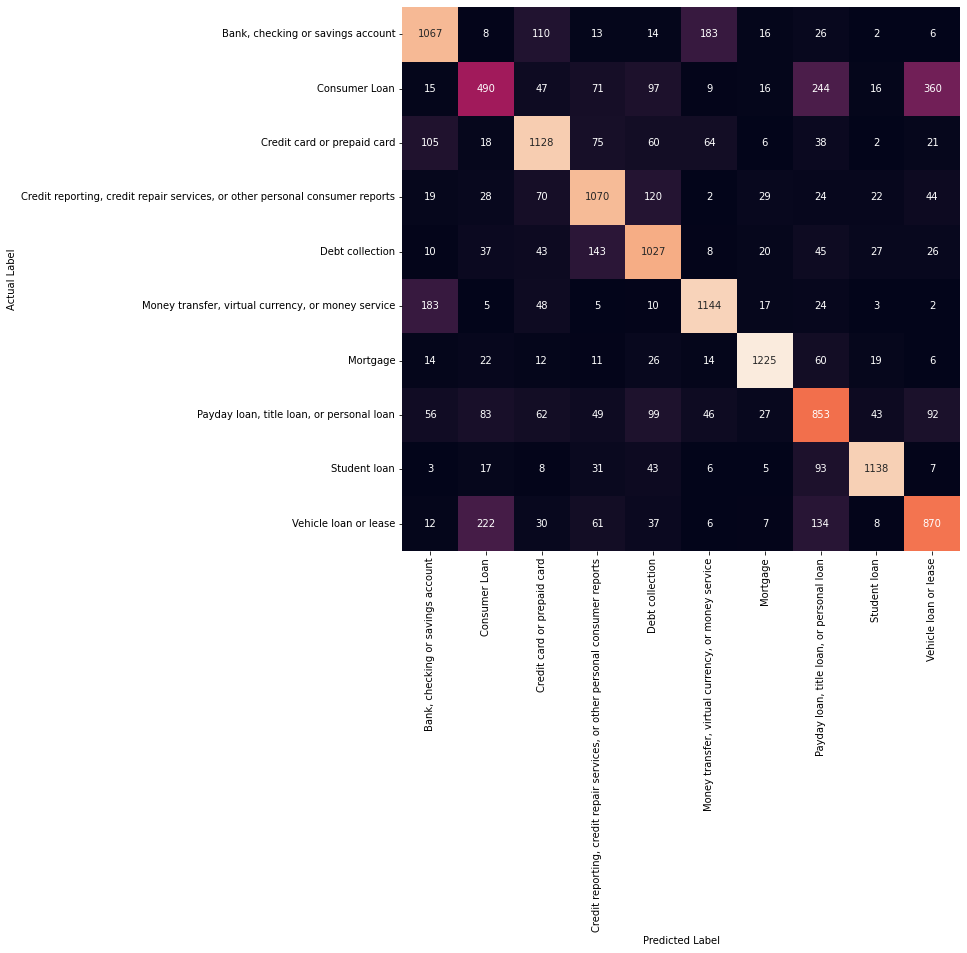

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)